In [2]:
import random
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split

from copy import deepcopy
# from mcts import mcts


from scipy import stats

In [30]:
import numpy as np

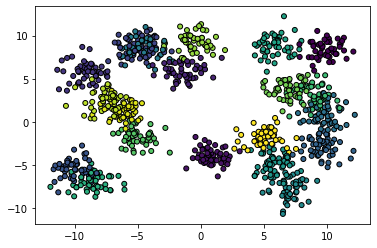

In [48]:
# Make blobs with 4 clutsers, low high and median fit ness
seed= np.random.randint(0,1000)
X1, Type,C = make_blobs(n_samples=1000, n_features=2, centers=20,random_state=seed,
                        return_centers=True)
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=Type, s=25, edgecolor="k")

Type 0: x0 small, x1 large; <br /> 
Type 1: x0 large, x1 large; <br /> 
Type 2: x0 small, x1 small; <br /> 
Type 3: x0 large, x1 small; <br /> 

In [4]:
Type[:8]

array([1, 3, 3, 0, 1, 3, 0, 2])

In [5]:
X1[:8]

array([[ 6.17214202,  7.67626811],
       [ 9.08188426, -9.16794702],
       [ 8.88107794, -8.75580511],
       [-3.99099027,  9.03072481],
       [ 5.18857506,  9.22037654],
       [ 9.20835038, -8.57718598],
       [-3.6671456 ,  8.89828602],
       [-6.57774625, -7.31895934]])

In [12]:
# Rule of generating random sequence
# Seqnece rules
def randDNA(length,base_dict):
    seq = [random.choice('CGTA') for _ in range(length)]
    for item in base_dict:
        seq[item] = base_dict[item]
    return (seq)

print(randDNA(5,{3:"A"}))

['C', 'C', 'A', 'A', 'A']


# Rule of sequence and Type
Dict format is class:{position1:base1,position2:base2}

In [7]:
# Custom rule of sequence of X1 and Type
# Dict format is class:{position1:base1,position2:base2}
# Type 0: x0 small, x1 large;
# Type 1: x0 large, x1 large;
# Type 2: x0 small, x1 small;
# Type 3: x0 large, x1 small;
Y_rule = {
    0:{1:"G", 3:"A",4:"A"},
    1:{3:"A",4:"A"},
    2:{2:"T",3:"A",4:"C"},
    3:{3:"A",4:"T"}
}    

In [8]:
X_seqs = [ randDNA(5,Y_rule[label])for label in Type]

In [14]:
X_seqs[:10]

[['G', 'T', 'C', 'A', 'A'],
 ['G', 'A', 'G', 'A', 'T'],
 ['T', 'A', 'C', 'A', 'T'],
 ['C', 'G', 'G', 'A', 'A'],
 ['A', 'C', 'T', 'A', 'A'],
 ['T', 'A', 'G', 'A', 'T'],
 ['T', 'G', 'G', 'A', 'A'],
 ['G', 'G', 'T', 'A', 'C'],
 ['A', 'T', 'T', 'A', 'C'],
 ['G', 'G', 'T', 'A', 'T']]

In [19]:
# One hot encoding of the input
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_seqs);

In [20]:
enc.categories_

[array(['A', 'C', 'G', 'T'], dtype=object),
 array(['A', 'C', 'G', 'T'], dtype=object),
 array(['A', 'C', 'G', 'T'], dtype=object),
 array(['A'], dtype=object),
 array(['A', 'C', 'T'], dtype=object)]

In [21]:
X_features = enc.transform(X_seqs).toarray()

In [22]:
X_features.shape

(100, 16)

# Train and test random forest regressor on the generated dataset

In [13]:
# Test train split with 20% and 80%
X_train, X_test, y_train, y_test = train_test_split(
    X_features, X1, test_size=0.2, random_state=42)

In [14]:
regressor = MultiOutputRegressor(RandomForestRegressor(random_state=0)).fit(X_train, y_train)
y_predict = regressor.predict(X_test)

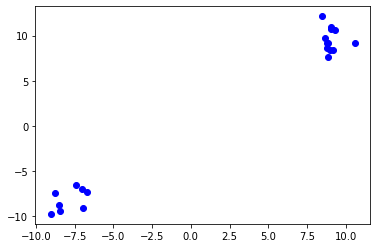

In [15]:
plt.scatter(y_predict[:,1], y_test[:,1],color='b') 

In [16]:
print(stats.pearsonr(y_test[:,1],y_predict[:,1]))

(0.9893858284767539, 1.5627451068803245e-16)


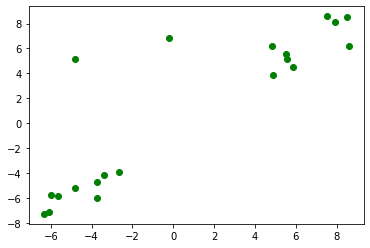

In [17]:
plt.scatter(y_predict[:,0], y_test[:,0],color='g') 

In [18]:
print(stats.pearsonr(y_test[:,0],y_predict[:,0]))

(0.8776017116232642, 3.7248672696526816e-07)


# Monte carlo tree search demo

Random forest to predict reward <br /> 
pip install mcts <br /> 
Tutorial of the State and Action class see: <br /> 
https://github.com/pbsinclair42/MCTS <br /> 

In [19]:
class SequenceDesignState():
    def __init__(self,regressor,encoder):
        # Require a regressor and a encoder
        # Empty sequence by default
        # Single player game
        # Regressor and encoder to cal reward
        self.sequence = []
        self.currentPlayer = 1
        self.regressor = regressor
        self.encoder = encoder

    def getCurrentPlayer(self):
        return self.currentPlayer

    def getPossibleActions(self):
        # Actions are appending a base to the current sqeunce
        possibleActions = []
        for b in ['A','T','C','G']:
            possibleActions.append(Action(player=self.currentPlayer, base=b))
        return possibleActions

    def takeAction(self, action):
        # Actions are appending a base to the current sqeunce
        newState = deepcopy(self)
        newState.sequence.append(action.base) 
        return newState

    def isTerminal(self):
        # Terminal state is that seq len == 5
        if(len(self.sequence)==5):
            return True
        else:
            return False
    
    def getReward(self):
        # Reward is the sum of the two score predicted by the model
        seq_encoded = self.encoder.transform([self.sequence])
        score = regressor.predict(seq_encoded)
        return score.sum()


class Action():
    def __init__(self, player, base):
        # Single player
        # Action only include base 
        self.player = player
        self.base = base

    def __str__(self):
        return str(self.base)

    def __repr__(self):
        return str(self)

    def __eq__(self, other):
        return self.__class__ == other.__class__ and self.base == other.base and self.player == other.player

    def __hash__(self):
        return hash((self.base, self.player))

In [20]:
initialState = SequenceDesignState(regressor=regressor,encoder=enc)
searcher = mcts(timeLimit=1000)
action = searcher.search(initialState=initialState)

In [21]:
currentState = initialState.takeAction(action)
print("Currerent sequence is: "+"".join(currentState.sequence))
print("Optimal base to add is: ")
print(action)

while len(currentState.sequence)<5:
    try:
        currentState = currentState.takeAction(action)
        print("Currerent sequence is: "+"".join(currentState.sequence))
        action = searcher.search(initialState=currentState)
        print("Optimal base to add is: ")
        print(action)
    except IndexError:
        print("Finish desgining sequence")

Currerent sequence is: A
Optimal base to add is: 
A
Currerent sequence is: AA
Optimal base to add is: 
G
Currerent sequence is: AAG
Optimal base to add is: 
T
Currerent sequence is: AAGT
Optimal base to add is: 
A
Currerent sequence is: AAGTA
Finish desgining sequence


In [22]:
# Show desgined sequence
currentState.sequence

['A', 'A', 'G', 'T', 'A']

# Predicted fitness & efficacy

In [23]:
regressor.predict(enc.transform([currentState.sequence]))

array([[4.77352284, 8.7619296 ]])